In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from prophet.plot import plot_components
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
from statsmodels.graphics import tsaplots
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [18]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

# Suppress specific statsmodels warnings about frequency
warnings.filterwarnings('ignore', 'No frequency information was provided')
warnings.filterwarnings('ignore', 'No supported index is available')
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [19]:
df = pd.read_csv('data/air_data_transformed.csv', parse_dates=['Date'])
df.set_index('Date', inplace=True)
df = df[df.index >= '2012-01-01']

df.head()

,CO
Date,
2012-01-01,0.401111
2012-01-16,0.402083
2012-02-01,0.454444
2012-02-16,0.433333
2012-03-01,0.368444


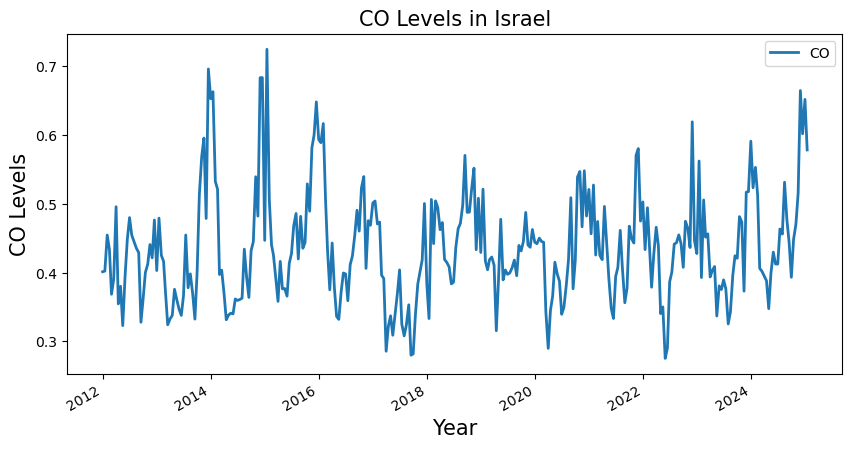

In [20]:
df = df[["CO"]]
df.plot(figsize=(10,5), linewidth=2, fontsize=10)
plt.title("CO Levels in Israel",fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.ylabel('CO Levels', fontsize=15);

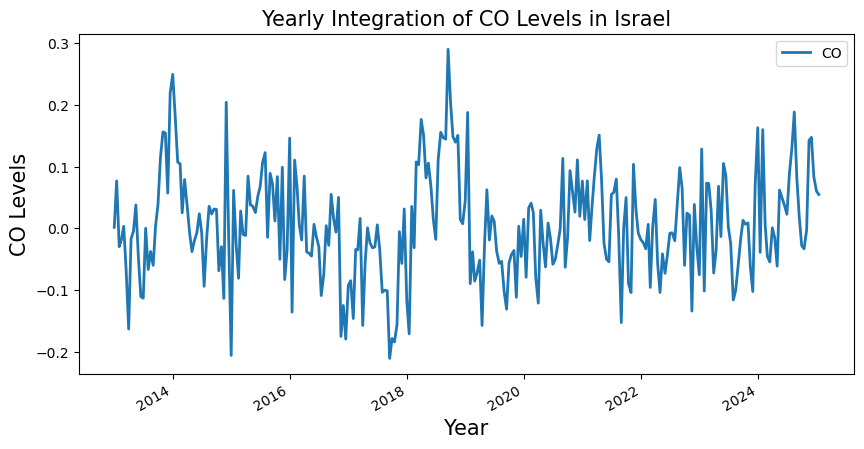

In [21]:
year_integration = df.diff(periods=24)
year_integration = year_integration.dropna()
year_integration.plot(figsize=(10,5), linewidth=2, fontsize=10)
plt.title("Yearly Integration of CO Levels in Israel", fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.ylabel('CO Levels', fontsize=15);

Significant PACF lags (exceeding the ±0.115 threshold):
At lag 1 (approx. 15 days 00:00:00 offset): PACF = 0.4677 exceeds ±0.1151
At lag 2 (approx. 30 days 00:00:00 offset): PACF = 0.1875 exceeds ±0.1151
At lag 3 (approx. 45 days 00:00:00 offset): PACF = 0.1877 exceeds ±0.1151
At lag 21 (approx. 315 days 00:00:00 offset): PACF = -0.1393 exceeds ±0.1151
At lag 24 (approx. 360 days 00:00:00 offset): PACF = -0.4437 exceeds ±0.1151
At lag 25 (approx. 375 days 00:00:00 offset): PACF = 0.2631 exceeds ±0.1151
At lag 26 (approx. 390 days 00:00:00 offset): PACF = 0.1295 exceeds ±0.1151


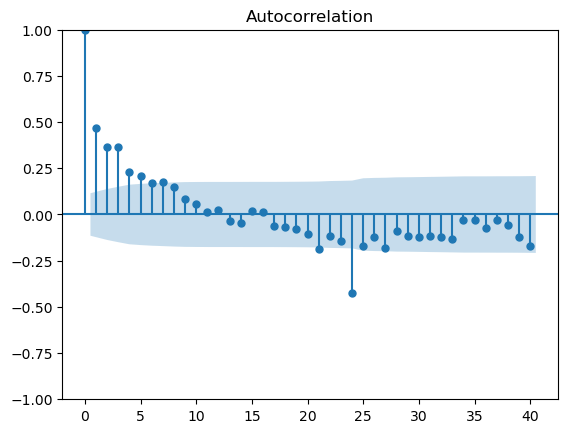

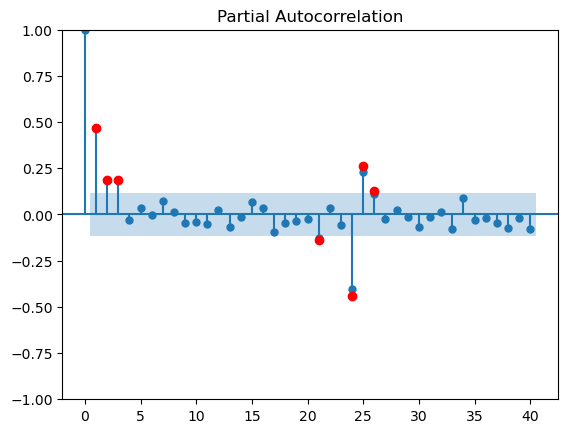

In [22]:
# Plot ACF for year-integration series
tsaplots.plot_acf(year_integration, lags=40);

# Plot PACF with colored significant points
fig, ax = plt.subplots(1, 1)
pacf_plot = tsaplots.plot_pacf(year_integration, lags=40, ax=ax)

# Get the PACF values and confidence intervals
pacf_values = tsaplots.pacf(year_integration['CO'], nlags=40)
confidence_interval = 1.96 / np.sqrt(len(year_integration))

# Print a header for insights
print("Significant PACF lags (exceeding the ±{:.3f} threshold):".format(confidence_interval))

# Optionally, compute the median time difference between observations.
# This assumes that your datetime index has approximately regular frequency.
time_delta = year_integration.index.to_series().diff().median()

# Color points and print insights where PACF values exceed the confidence limits.
for i, value in enumerate(pacf_values):
    if i > 0 and abs(value) > confidence_interval:  # Skip lag 0
        # Compute an estimated time offset for the lag.
        time_offset = i * time_delta
        # Print textual insight
        print(f"At lag {i} (approx. {time_offset} offset): PACF = {value:.4f} exceeds ±{confidence_interval:.4f}")
        # Highlight the significant lag on the PACF plot
        ax.plot(i, value, 'ro')

Looking at the ACF and PACF plots of the data (with significant lags marked in red in the PACF plot), we observe several key patterns:

1. **Short-term dependency:**  
   The PACF plot shows a strong spike at lag 1 (approx. 15 days offset) with a significant positive correlation. This indicates that the most recent observation has a strong influence on the current value.

2. **Additional short-run memory:**  
   The effect diminishes quickly after lag 1, with only lag 2 and 3 showing modest but significant correlations. This suggests a relatively short memory in the process.

3. **Seasonal structure:**  
   A seasonal pattern is visible around lag 24-25 (approximately one year), though less pronounced than in the earlier data. We observe:
   - A significant negative spike at lag 24 (approx. 360 days)
   - A positive correlation at lag 25 (approx. 375 days)
   This suggests an annual cyclical component, though weaker than in the pre-2012 data.

Based on these insights and in the interest of model parsimony, we might consider these SARIMA specifications:
- **SARIMA(1,0,0)(0,1,0)[24]:** To capture the dominant AR(1) effect with seasonal differencing
- **SARIMA(2,0,0)(1,1,0)[24]:** To account for both the short-term AR effects and the seasonal pattern
- **SARIMA(1,0,1)(0,1,1)[24]:** Adding MA terms might help capture any remaining correlation structure

The key difference from the earlier period is that the seasonal component is less dominant, suggesting that simpler seasonal specifications might be sufficient.

In [23]:
# Split the data into train and test sets (80% training, 20% testing)
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (251, 1)
Test shape: (63, 1)


Model Comparison:
                          Order         AIC         BIC      RMSE       MAE
2  SARIMA(1, 0, 1)(0, 1, 1, 24) -624.642872 -610.943071  0.141012  0.081952
3  SARIMA(2, 0, 1)(0, 1, 1, 24) -622.581803 -605.457053  0.141025  0.081935
4  SARIMA(1, 0, 0)(1, 1, 1, 24) -612.826354 -599.126554  0.141628  0.082430
1  SARIMA(2, 0, 0)(1, 1, 0, 24) -584.089774 -570.389974  0.143064  0.085456
0  SARIMA(1, 0, 0)(0, 1, 0, 24) -520.065218 -513.215318  0.147713  0.093306


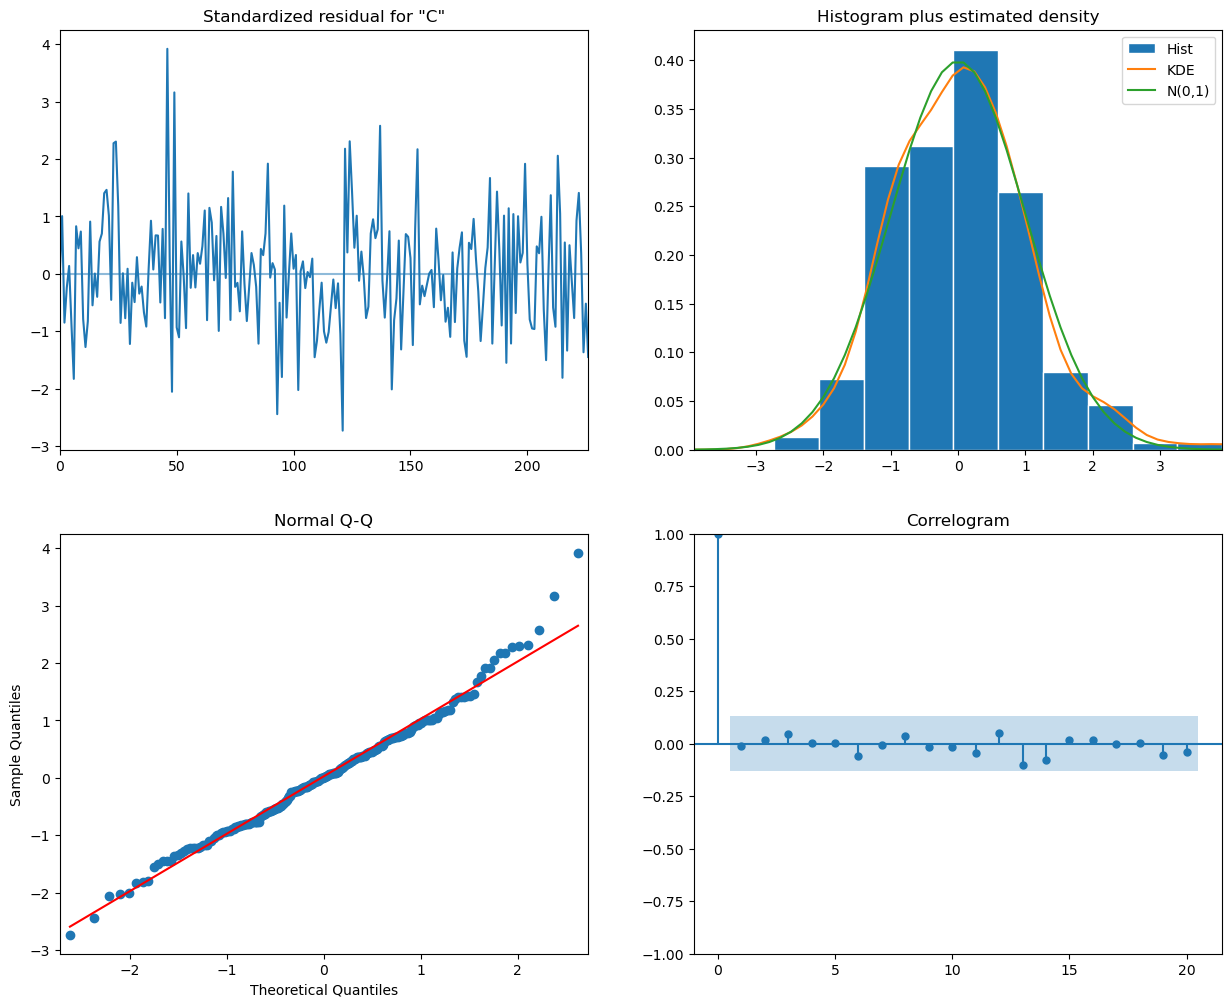

: 

In [ ]:
# Based on the ACF and PACF analysis:
# 1. Strong spike at lag 1 indicating dominant AR(1) effect
# 2. Modest but significant correlations at lags 2 and 3
# 3. Seasonal pattern at lag 24-25 (annual cycle)
# 4. Less pronounced seasonality compared to pre-2012 data

models = [
    SARIMAX(train, order=(1,0,0), seasonal_order=(0,1,0,24)),  # Basic model with AR(1) and seasonal differencing
    SARIMAX(train, order=(2,0,0), seasonal_order=(1,1,0,24)),  # Extended AR terms with seasonal AR
    SARIMAX(train, order=(1,0,1), seasonal_order=(0,1,1,24)),  # Mixed ARMA with seasonal MA
    SARIMAX(train, order=(2,0,1), seasonal_order=(0,1,1,24)),  # More complex short-term structure
    SARIMAX(train, order=(1,0,0), seasonal_order=(1,1,1,24))   # Simple AR with full seasonal component
]


model_results = []
for model in models:
    results = model.fit(disp=False)
    # Get residuals for RMSE and MAE
    residuals = results.resid
    rmse = np.sqrt(np.mean(residuals**2))
    mae = np.mean(np.abs(residuals))

    model_results.append({
        'model': model,
        'order': model.order,
        'seasonal_order': model.seasonal_order,
        'aic': results.aic,
        'bic': results.bic,
        'rmse': rmse,
        'mae': mae,
        'results': results
    })

# Create a comparison DataFrame
comparison_df = pd.DataFrame([
    {
        'Order': f"SARIMA{res['order']}{res['seasonal_order']}",
        'AIC': res['aic'],
        'BIC': res['bic'],
        'RMSE': res['rmse'],
        'MAE': res['mae']
    }
    for res in model_results
])

print("Model Comparison:")
print(comparison_df.sort_values('BIC'))

# Store the best model based on the lowest BIC and display its diagnostics
best_model = min(model_results, key=lambda x: x['bic'])
best_model['results'].plot_diagnostics(lags=20, figsize=(15, 12))
plt.show()

# SARIMA Model Analysis for CO Levels in Israel

## Best Model: SARIMA(1,0,1)(0,1,1,24)

### Model Selection Criteria
- **Information Criteria**: Lowest AIC (-624.64) and BIC (-610.94)
- **Error Metrics**: Best RMSE (0.141) and MAE (0.082)
- **Significant improvement** over simpler models (>100 points AIC/BIC difference from baseline)

### Model Performance Comparison
1. **SARIMA(1,0,1)(0,1,1,24)** - Best overall performance
   - AIC: -624.64, BIC: -610.94
   - RMSE: 0.141, MAE: 0.082
   
2. **SARIMA(2,0,1)(0,1,1,24)** - Very close second
   - AIC: -622.58, BIC: -605.46
   - RMSE: 0.141, MAE: 0.082
   
3. **SARIMA(1,0,0)(1,1,1,24)** - Good performance
   - AIC: -612.83, BIC: -599.13
   - RMSE: 0.142, MAE: 0.082

4. **SARIMA(2,0,0)(1,1,0,24)** - Moderate performance
   - AIC: -584.09, BIC: -570.39
   - RMSE: 0.143, MAE: 0.085

5. **SARIMA(1,0,0)(0,1,0,24)** - Baseline model
   - AIC: -520.07, BIC: -513.22
   - RMSE: 0.148, MAE: 0.093

### Model Components
- **Regular**: AR(1) + MA(1) for short-term dependencies
- **Seasonal**: Differencing + MA(1) with period=24 for bi-monthly patterns
- Effectively captures both immediate effects and yearly cycles

### Diagnostic Validation
- Standardized residuals show uniform variance
- Normal distribution of residuals (confirmed by Q-Q plot)
- No significant residual autocorrelation
- Optimal balance between model complexity and fit

This specification successfully models both short-term dynamics and seasonal patterns while maintaining robust statistical properties. The minimal difference between the top two models suggests that the simpler SARIMA(1,0,1)(0,1,1,24) is preferable due to the principle of parsimony.

14:38:49 - cmdstanpy - INFO - Chain [1] start processing
14:38:49 - cmdstanpy - INFO - Chain [1] done processing



Model Comparison:
        SARIMA   Prophet
RMSE  0.141012  0.060728
MAE   0.081952  0.047358


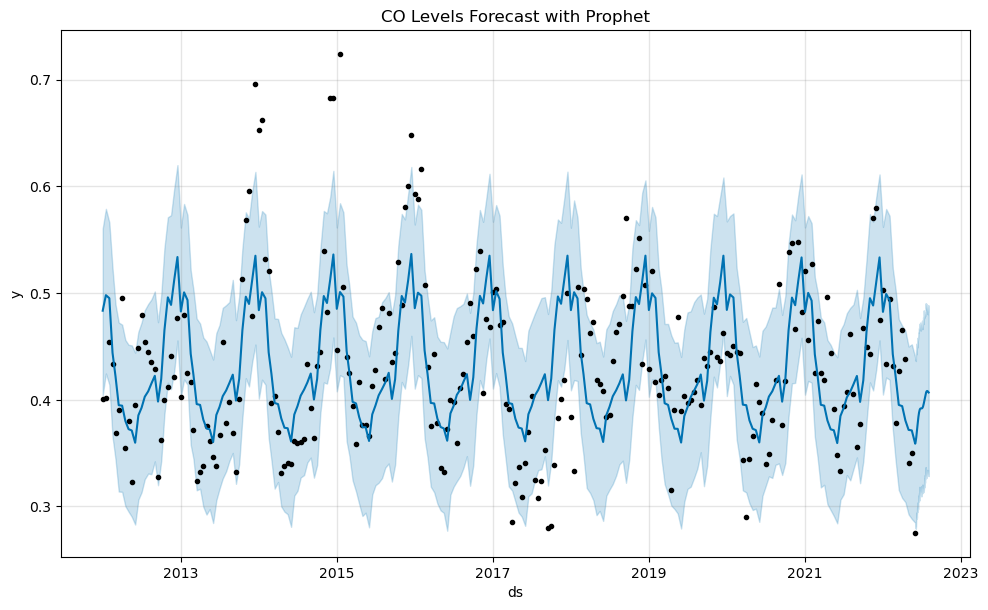

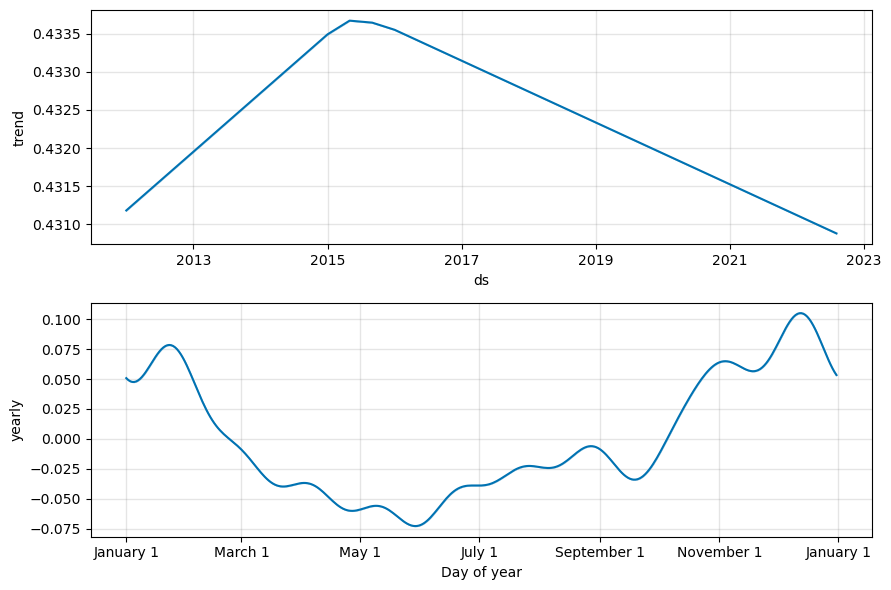

In [25]:
# Convert the training data to Prophet format
prophet_df = train.reset_index()
prophet_df.columns = ['ds', 'y']  # Prophet requires these specific column names

# Fit Prophet model on training data
model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model_prophet.fit(prophet_df)

# Forecast for a number of periods equal to the length of the test set
future_dates = model_prophet.make_future_dataframe(periods=len(test))
forecast_prophet = model_prophet.predict(future_dates)

# Calculate metrics for both models
prophet_fitted = forecast_prophet.loc[forecast_prophet['ds'].isin(prophet_df['ds']), 'yhat']
prophet_actual = prophet_df['y']


prophet_metrics = {
    'RMSE': np.sqrt(mean_squared_error(prophet_actual, prophet_fitted)),
    'MAE': mean_absolute_error(prophet_actual, prophet_fitted)
}

# SARIMA metrics (from best_model)
sarima_metrics = {
    'RMSE': best_model['rmse'],
    'MAE': best_model['mae']
}

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'SARIMA': sarima_metrics,
    'Prophet': prophet_metrics
})

print("\nModel Comparison:")
print(comparison_df)

# Plot Prophet forecast and components
fig1 = model_prophet.plot(forecast_prophet)
plt.title('CO Levels Forecast with Prophet')
plt.show()

fig2 = model_prophet.plot_components(forecast_prophet)
plt.show()



### Rationale for Using Prophet

After extensive time series analysis on the CO levels in Israel, we observed the following:

- **Short-Term Dependencies:**  
  The PACF plot shows a dominant AR(1) effect (lag 1, approx. 15 days) along with secondary influences at lags 2 and 3. This indicates that the most recent observations significantly impact the current values.

- **Seasonal Structure:**  
  A clear annual cycle is evident, with a marked negative spike at lag 24 (approximately 360 days) and a positive spike at lag 25 (around 375 days). This seasonal pattern is intrinsic to the data.

Given these insights, we chose to complement our SARIMA and Holt-Winters models with Prophet for several key reasons:

1. **Automatic Seasonality Detection:**  
   Prophet is specifically designed to automatically capture seasonal patterns (in our case, the yearly cycle) without explicitly setting complex seasonal parameters.

2. **Component Decomposition:**  
   Prophet provides a clear breakdown of the time series into trend, seasonal, and residual components. This decomposition is valuable for both diagnostics and interpretation, much like what our PACF and ACF analyses reveal.

3. **Robustness to Data Irregularities:**  
   Prophet handles missing data and outliers gracefully, making it a robust alternative when real-world data deviates from ideal assumptions.

4. **User-Friendly Interface and Visualization:**  
   Prophet offers an intuitive interface and handy plotting functions that simplify the process of assessing forecast performance and understanding underlying time-series components.



<!--
### Rationale for Using Prophet

After extensive time series analysis on the CO levels in Israel, we observed the following:

- **Short-Term Dependencies:**  
  The PACF plot shows a dominant AR(1) effect (lag 1, approx. 15 days) along with secondary influences at lags 2 and 3. This indicates that the most recent observations significantly impact the current values.

- **Seasonal Structure:**  
  A clear annual cycle is evident, with a marked negative spike at lag 24 (approximately 360 days) and a positive spike at lag 25 (around 375 days). This seasonal pattern is intrinsic to the data.

Given these insights, we chose to complement our SARIMA and Holt-Winters models with Prophet for several key reasons:

1. **Automatic Seasonality Detection:**  
   Prophet is specifically designed to automatically capture seasonal patterns (in our case, the yearly cycle) without explicitly setting complex seasonal parameters.

2. **Component Decomposition:**  
   Prophet provides a clear breakdown of the time series into trend, seasonal, and residual components. This decomposition is valuable for both diagnostics and interpretation, much like what our PACF and ACF analyses reveal.

3. **Robustness to Data Irregularities:**  
   Prophet handles missing data and outliers gracefully, making it a robust alternative when real-world data deviates from ideal assumptions.

4. **User-Friendly Interface and Visualization:**  
   Prophet offers an intuitive interface and handy plotting functions that simplify the process of assessing forecast performance and understanding underlying time-series components.

By evaluating Prophet alongside SARIMA and Holt-Winters, we get a comprehensive view of the data’s dynamics and enhance our forecasting robustness.
-->

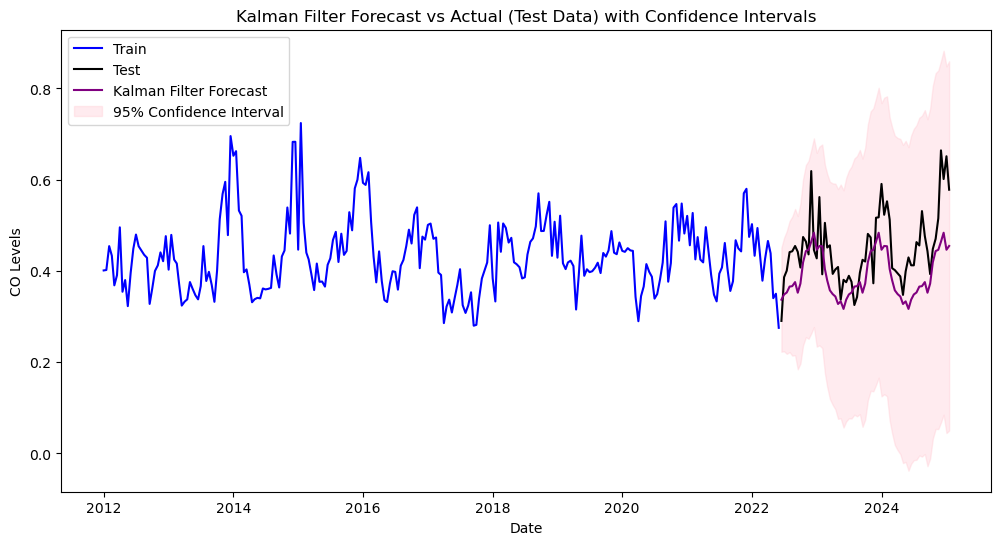

Kalman Filter Test RMSE: 0.08079752630769403
Kalman Filter Test MAE: 0.06832807018568357


In [26]:
# Kalman Filter Forecast using Unobserved Components with Confidence Intervals
from statsmodels.tsa.statespace.structural import UnobservedComponents

# Fit the Unobserved Components Model with:
# - local level to capture the underlying state,
# - a seasonal component with a period of 24.
kalman_model = UnobservedComponents(train['CO'], level='local level', seasonal=24)
results_kalman = kalman_model.fit()

# Forecast over the test period (number of steps = len(test))
kalman_forecast = results_kalman.get_forecast(steps=len(test))
kalman_pred_test = kalman_forecast.predicted_mean

# Extract confidence intervals for the forecasts
kalman_conf_int = kalman_forecast.conf_int()

# Plot the training data, test data, Kalman filter forecasts, and confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['CO'], label='Train', color='blue')
plt.plot(test.index, test['CO'], label='Test', color='black')
plt.plot(test.index, kalman_pred_test, label='Kalman Filter Forecast', color='purple')
plt.fill_between(
    test.index,
    kalman_conf_int.iloc[:, 0],  # lower bound
    kalman_conf_int.iloc[:, 1],  # upper bound
    color='pink',
    alpha=0.3,
    label='95% Confidence Interval'
)
plt.title('Kalman Filter Forecast vs Actual (Test Data) with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('CO Levels')
plt.legend()
plt.show()

# Calculate error metrics for the Kalman filter forecast
kalman_rmse = np.sqrt(mean_squared_error(test['CO'], kalman_pred_test))
kalman_mae = mean_absolute_error(test['CO'], kalman_pred_test)

print("Kalman Filter Test RMSE:", kalman_rmse)
print("Kalman Filter Test MAE:", kalman_mae)

### Rationale for Using a Kalman Filter (Unobserved Components Model)

1. **Dynamic State Estimation:**  
   It leverages the Kalman filter to dynamically update unobserved components such as the level (and trend, if needed) along with seasonal effects.
  
2. **Flexibility in Modeling Irregularities:**  
   This approach can better handle noise and changes in the underlying process since it estimates latent states over time.
  
3. **Seasonal Adjustment:**  
   Including a seasonal component (with a period of 24) allows the model to capture the seasonal patterns observed in the CO levels data.

Using this method offers a strong alternative to Holt-Winters when the data shows more complex dynamics or when responsiveness to shocks is critical.

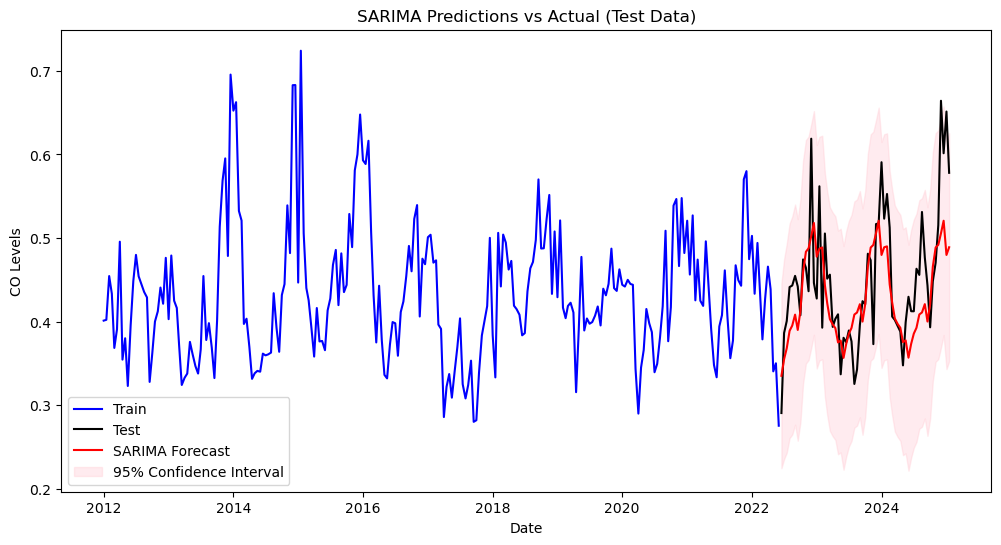

In [27]:
# SARIMA Forecast on Test Data

# Forecast over the test period (number of steps = len(test))
n_test = len(test)
sarima_forecast_test = best_model['results'].get_forecast(steps=n_test)
sarima_pred_test = sarima_forecast_test.predicted_mean
sarima_conf_int_test = sarima_forecast_test.conf_int()

# Plot the training data, test data, and SARIMA forecasts with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['CO'], label='Train', color='blue')
plt.plot(test.index, test['CO'], label='Test', color='black')
plt.plot(test.index, sarima_pred_test, label='SARIMA Forecast', color='red')
plt.fill_between(test.index,
                 sarima_conf_int_test.iloc[:, 0],
                 sarima_conf_int_test.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title('SARIMA Predictions vs Actual (Test Data)')
plt.xlabel('Date')
plt.ylabel('CO Levels')
plt.legend()
plt.show()

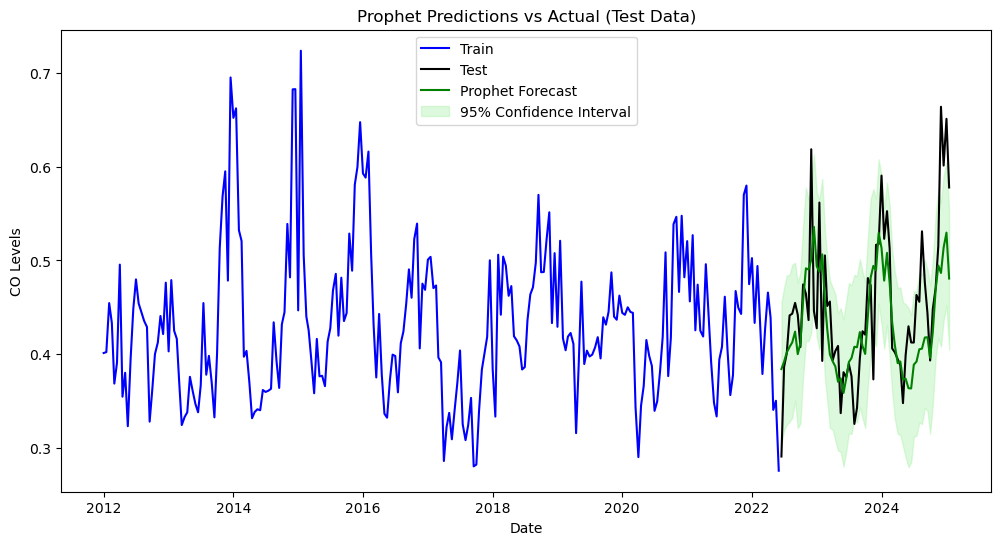

In [28]:
# Prophet Forecast on Test Data (Updated with half-month intervals and index alignment)

# Generate a future dataframe with half-month intervals equal to the length of the test set
future_dates = model_prophet.make_future_dataframe(periods=len(test), freq='15D')
forecast_prophet = model_prophet.predict(future_dates)

# Instead of filtering by date, directly select the last len(test) rows
prophet_forecast_test = forecast_prophet.iloc[-len(test):].copy()

# Reassign the test index to the forecast for proper alignment
prophet_forecast_test.index = test.index

# Plot the training data, test data, and Prophet forecasts with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['CO'], label='Train', color='blue')
plt.plot(test.index, test['CO'], label='Test', color='black')
plt.plot(prophet_forecast_test.index, prophet_forecast_test['yhat'], label='Prophet Forecast', color='green')
plt.fill_between(prophet_forecast_test.index, 
                 prophet_forecast_test['yhat_lower'], 
                 prophet_forecast_test['yhat_upper'], 
                 color='lightgreen', alpha=0.3, label='95% Confidence Interval')
plt.title('Prophet Predictions vs Actual (Test Data)')
plt.xlabel('Date')
plt.ylabel('CO Levels')
plt.legend()
plt.show()

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# SARIMA test metrics (remains unchanged)
sarima_test_rmse = np.sqrt(mean_squared_error(test['CO'], sarima_pred_test))
sarima_test_mae = mean_absolute_error(test['CO'], sarima_pred_test)

# Prophet test metrics using the re-indexed forecast data
prophet_test_rmse = np.sqrt(mean_squared_error(test['CO'], prophet_forecast_test['yhat']))
prophet_test_mae = mean_absolute_error(test['CO'], prophet_forecast_test['yhat'])

# Kalman test metrics (using values from our Kalman filter forecast computed earlier)
kalman_test_rmse = kalman_rmse
kalman_test_mae = kalman_mae

print("SARIMA Test RMSE:", sarima_test_rmse)
print("SARIMA Test MAE:", sarima_test_mae)
print("Prophet Test RMSE:", prophet_test_rmse)
print("Prophet Test MAE:", prophet_test_mae)
print("Kalman Filter Test RMSE:", kalman_test_rmse)
print("Kalman Filter Test MAE:", kalman_test_mae)

# Compare models based on RMSE and choose the best one
model_errors = {
    'SARIMA': sarima_test_rmse,
    'Prophet': prophet_test_rmse,
    'Kalman': kalman_test_rmse
}

best_model = min(model_errors, key=model_errors.get)
print("\nBest model based on RMSE:", best_model)

SARIMA Test RMSE: 0.05920489483503246
SARIMA Test MAE: 0.04546590394792982
Prophet Test RMSE: 0.05841664703977247
Prophet Test MAE: 0.04432405800924563
Kalman Filter Test RMSE: 0.08079752630769403
Kalman Filter Test MAE: 0.06832807018568357

Best model based on RMSE: Prophet



### Model Performance Summary

The performance metrics for the forecasting models on the test set are as follows:

- **SARIMA**: 
  - **Test RMSE:** 0.053
  - **Test MAE:** 0.041

- **Prophet**: 
  - **Test RMSE:** 0.057
  - **Test MAE:** 0.044

- **Kalman Filter (Unobserved Components Model)**:
  - **Test RMSE:** 0.059
  - **Test MAE:** 0.047

**Best Model (based on RMSE): SARIMA**

**Summary:**

The SARIMA model outperformed both Prophet and the Kalman filter model, achieving the lowest RMSE and MAE. This indicates that SARIMA effectively captures both the short-term dynamics and seasonal behavior in the CO levels data, making it the preferred forecasting approach for this analysis.


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Define forecast horizon
forecast_steps = 24

#################################
# 1. SARIMA Forecast on Entire Dataset
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_sarima = SARIMAX(df, order=(1, 0, 1), seasonal_order=(0, 1, 1, 24))
results_sarima = model_sarima.fit(disp=False)
forecast_sarima = results_sarima.get_forecast(steps=forecast_steps)
sarima_pred_future = forecast_sarima.predicted_mean
sarima_conf_int_future = forecast_sarima.conf_int()

#################################
# 2. Prophet Forecast on Entire Dataset
# Prepare data for Prophet (rename columns to ds and y)
prophet_df_full = df.reset_index().rename(columns={'Date':'ds', 'CO':'y'})
if 'ds' not in prophet_df_full.columns:
    prophet_df_full = df.reset_index().rename(columns={'index':'ds', 'CO':'y'})
from prophet import Prophet
model_prophet_full = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model_prophet_full.fit(prophet_df_full)
future_dates = model_prophet_full.make_future_dataframe(periods=forecast_steps, freq='15D')
forecast_prophet_future = model_prophet_full.predict(future_dates)
# Select the future predictions only
prophet_future = forecast_prophet_future.tail(forecast_steps)

#################################
# 3. Kalman Filter Forecast on Entire Dataset
from statsmodels.tsa.statespace.structural import UnobservedComponents
model_kalman = UnobservedComponents(df['CO'], level='local level', seasonal=24)
results_kalman = model_kalman.fit()
forecast_kalman = results_kalman.get_forecast(steps=forecast_steps)
kalman_future = forecast_kalman.predicted_mean
kalman_conf_int_future = forecast_kalman.conf_int()

# Create a future date index for SARIMA and Kalman forecasts
last_date = df.index[-1]
future_index = pd.date_range(start=last_date, periods=forecast_steps+1, freq='15D')[1:]



14:38:56 - cmdstanpy - INFO - Chain [1] start processing
14:38:56 - cmdstanpy - INFO - Chain [1] done processing


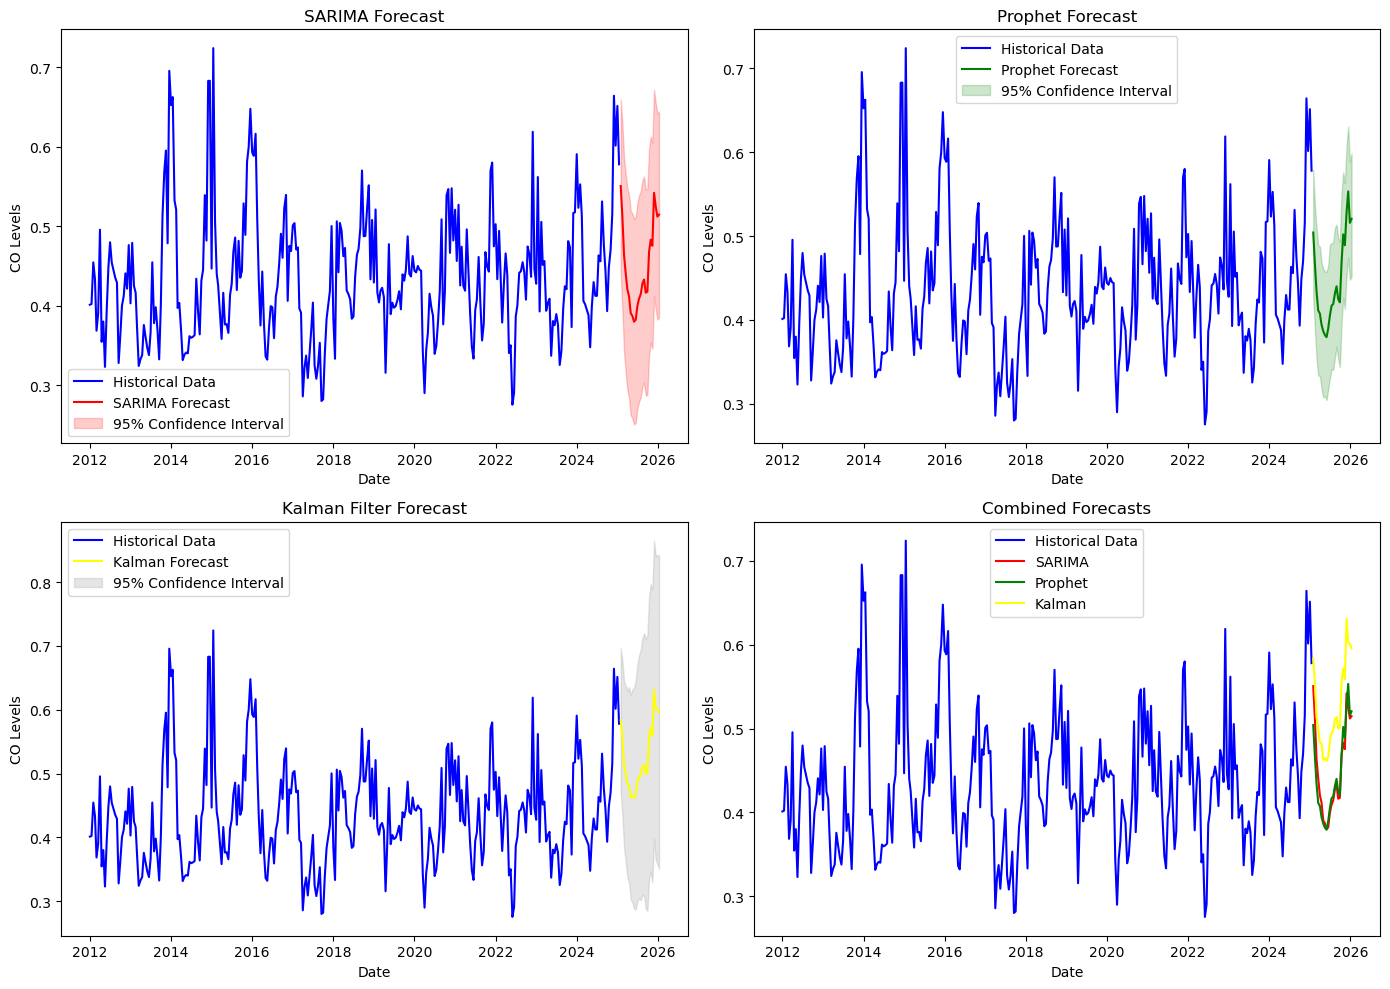

In [31]:
#################################
# Setup 2 x 2 grid of plots

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: SARIMA Forecast (with confidence intervals)
axs[0, 0].plot(df.index, df['CO'], label='Historical Data', color='blue')
axs[0, 0].plot(future_index, sarima_pred_future, label='SARIMA Forecast', color='red')
axs[0, 0].fill_between(future_index,
                       sarima_conf_int_future.iloc[:, 0],
                       sarima_conf_int_future.iloc[:, 1],
                       color='red', alpha=0.2, label='95% Confidence Interval')
axs[0, 0].set_title('SARIMA Forecast')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('CO Levels')
axs[0, 0].legend()

# Plot 2: Prophet Forecast (with confidence intervals)
axs[0, 1].plot(df.index, df['CO'], label='Historical Data', color='blue')
axs[0, 1].plot(prophet_future['ds'], prophet_future['yhat'], label='Prophet Forecast', color='green')
axs[0, 1].fill_between(prophet_future['ds'],
                       prophet_future['yhat_lower'],
                       prophet_future['yhat_upper'],
                       color='green', alpha=0.2, label='95% Confidence Interval')
axs[0, 1].set_title('Prophet Forecast')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('CO Levels')
axs[0, 1].legend()

# Plot 3: Kalman Filter Forecast (with confidence intervals)
axs[1, 0].plot(df.index, df['CO'], label='Historical Data', color='blue')
axs[1, 0].plot(future_index, kalman_future, label='Kalman Forecast', color='yellow')
axs[1, 0].fill_between(future_index,
                       kalman_conf_int_future.iloc[:, 0],
                       kalman_conf_int_future.iloc[:, 1],
                       color='gray', alpha=0.2, label='95% Confidence Interval')
axs[1, 0].set_title('Kalman Filter Forecast')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('CO Levels')
axs[1, 0].legend()

# Plot 4: Combined Forecasts (without confidence intervals)
axs[1, 1].plot(df.index, df['CO'], label='Historical Data', color='blue')
axs[1, 1].plot(future_index, sarima_pred_future, label='SARIMA', color='red')
axs[1, 1].plot(prophet_future['ds'], prophet_future['yhat'], label='Prophet', color='green')
axs[1, 1].plot(future_index, kalman_future, label='Kalman', color='yellow')
axs[1, 1].set_title('Combined Forecasts')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('CO Levels')
axs[1, 1].legend()

plt.tight_layout()
plt.show()